# Notebook 12: Identifying Phases in the 2D Ising Model with TensorFlow


## Learning Goal
The goal of this notebook is to familiarize the reader with the nuts and bolts on using the TensorFlow package for building Deep Neural Networks.

## Overview

In this notebook, we show how one can use deep neural nets to classify the states of the 2D Ising model according to their phase. This should be compared with the use of logistic-regression, Random Forests and XG Boost on the same dataset in the previous Notebooks 6 and 9.

The Hamiltonian for the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.

In [1]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import, division, print_function
import numpy as np
seed=12
np.random.seed(seed)
import sys, os, argparse
import tensorflow as tf
from tensorflow.python.framework import dtypes
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

## Structure of the Procedure

Constructing a Deep Neural Network to solve ML problems is a multiple-stage process. Quite generally, one can identify the key steps as follows:

* ***step 1:*** Load and process the data
* ***step 2:*** Define the model and its architecture
* ***step 3:*** Choose the optimizer and the cost function
* ***step 4:*** Train the model 
* ***step 5:*** Evaluate the model performance on the *unseen* test data
* ***step 6:*** Modify the hyperparameters to optimise performance for the specific data set

Below, we sometimes combine some of these steps together for convenience.

Notice that we take a rather different approach, compared to the simpler MNIST Keras notebook. We first define a set of classes and functions and run the actual computation only in the very end.

### Step 1: Load and Process the Data

We begin by writing a `DataSet` class and two functions `read_data_sets` and `load_data` to process the 2D Ising data. 

The `DataSet` class performs checks on the data shape and casts the data into the correct data type for the calculation. It contains a function method called `next_batch` which shuffles the data and returns a mini-batch of a pre-defined size. This structure is particularly useful for the training procedure in TensorFlow.

In [2]:
class DataSet(object):

    def __init__(self,data_X,data_Y,dtype=dtypes.float32):
        """Checks data and casts it into correct data type. """

        dtype = dtypes.as_dtype(dtype).base_dtype
        if dtype not in (dtypes.uint8, dtypes.float32):
            raise TypeError('Invalid dtype %r, expected uint8 or float32' % dtype)

        assert data_X.shape[0] == data_Y.shape[0], ('data_X.shape: %s data_Y.shape: %s' % (data_X.shape, data_Y.shape))
        self.num_examples = data_X.shape[0]

        if dtype == dtypes.float32:
            data_X = data_X.astype(np.float32)
        self.data_X = data_X
        self.data_Y = data_Y 

        self.epochs_completed = 0
        self.index_in_epoch = 0

    def next_batch(self, batch_size, seed=None):
        """Return the next `batch_size` examples from this data set."""

        if seed:
            np.random.seed(seed)

        start = self.index_in_epoch
        self.index_in_epoch += batch_size
        if self.index_in_epoch > self.num_examples:
            # Finished epoch
            self.epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.data_X = self.data_X[perm]
            self.data_Y = self.data_Y[perm]
            # Start next epoch
            start = 0
            self.index_in_epoch = batch_size
            assert batch_size <= self.num_examples
        end = self.index_in_epoch

        return self.data_X[start:end], self.data_Y[start:end]

The data itself are being processed in the function `read_data_sets`, which loads the Ising dataset, and splits it into three subsets: ordered, critical and disordered, depending on the temperature which sets the distribution they are drawn from. Once again, we use the ordered and disordered data to create a training and a test data set for the problem. Classifying the states in the critical region is expected to be harder and we only use this data to test the performance of our model in the end.

In [10]:
def read_data_set(pkl_file,root_dir,dtype=dtypes.float32,train_size=80000,validation_size=5000):

    import pickle
    from sklearn.model_selection import train_test_split
    from keras.utils import to_categorical
    import collections

    L=40 # linear system size

    # path to data directory
    # path to data directory
    path_to_data=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

    # load data
    file_name = "Ising2DFM_reSample_L40_T=All.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
    data = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (1D array, compressed bits)
    data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
    data=data.astype('int')
    data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

    file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl" # this file contains 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25)
    labels = pickle.load(open(path_to_data+file_name,'rb')) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

    # divide data into ordered, critical and disordered
    X_ordered=data[:70000,:]
    Y_ordered=labels[:70000]

    X_critical=data[70000:100000,:]
    Y_critical=labels[70000:100000]

    X_disordered=data[100000:,:]
    Y_disordered=labels[100000:]

    del data,labels

    # define training and test data sets
    X=np.concatenate((X_ordered,X_disordered)) #np.concatenate((X_ordered,X_critical,X_disordered))
    Y=np.concatenate((Y_ordered,Y_disordered)) #np.concatenate((Y_ordered,Y_critical,Y_disordered))

    del X_ordered, X_disordered, Y_ordered, Y_disordered

    # pick random data points from ordered and disordered states to create the training and test sets
    X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_size)

    del X,Y

    # make data categorical
    Y_train=to_categorical(Y_train)
    Y_test=to_categorical(Y_test)
    Y_critical=to_categorical(Y_critical)


    if not 0 <= validation_size <= len(X_train):
        raise ValueError('Validation size should be between 0 and {}. Received: {}.'.format(len(X_train), validation_size))

    X_validation = X_train[:validation_size]
    Y_validation = Y_train[:validation_size]
    X_train = X_train[validation_size:]
    Y_train = Y_train[validation_size:]

    # create data sets
    train = DataSet(X_train, Y_train, dtype=dtype)
    validation = DataSet(X_validation, Y_validation, dtype=dtype)
    test = DataSet(X_test, Y_test, dtype=dtype)
    critical = DataSet(X_critical, Y_critical, dtype=dtype)

    Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test', 'critical'])

    print("finished processing data")

    return Datasets(train=train, validation=validation, test=test, critical=critical)

The `DataSet` class and the `read_data_sets` function are wrapped in another function: `load_data`. To call the latter, one specifies the sizes for the training, test and validation data sets. This function also contains the local path to the file with the Ising data. 

In [11]:
def load_data():

    n_samples=100000
    train_size=70000
    validation_size=0

    # Preprocess data
    pkl_file='mag_vs_T_L40_T=3.50.pkl'
    root_dir=os.path.expanduser('~')+'/Dropbox/MachineLearningReview/Datasets/isingMC/'

    return read_data_set(pkl_file,root_dir,train_size=train_size,validation_size=validation_size)

### Steps 2+3: Define the Neural Net and its Architecture, Choose the Optimizer and the Cost Function

We can now move on to construct our deep neural net using TensorFlow. To do this, we create a class called `model`. This class contains many useful function methods which break down the construction of the DNN. Unique for TensorFlow is creating placeholders for the variables of the model, such as the feed-in data `self.X` and `self.Y` or the dropout probability `self.dropout_keepprob` (which has to be set to unity explicitly during testing). Another peculiarity is using the `with` scope to give names to the most important operators. While we do not discuss this here, TensorFlow also allows one to visualise the computational graph for the model (see package documentation on [https://www.tensorflow.org/](https://www.tensorflow.org/)).

To classify whether a given spin configuration is in the ordered or disordered phase, we construct a minimalistic model for a DNN with a single hidden layer containing $N_\mathrm{neurons}$ (which is kept variable so we can try out the performance of different sizes for the hidden layer). 

First, we define two private functions: `_weight_variable` and `_bias_variable`, which we use to set up the precise DNN architecture in the function `create_DNN`. The network architecture thus includes a ReLU-activated input layer, the hidden layer, and the softmax output layer. Notice that the softmax layer is _not_ part of the `create_DNN` function.

Instead, the softmax layer is part of the function `create_loss` which, as the name suggests, defines the cross entropy loss function, predefined in TensorFlow's `nn` module. We minimize the cost function using the `SGD` optimizer from the `train` module in the function `create_optimiser`. The latter accepts a dictionary `opt_kwargs` with optimizer arguments to be set externally when defining the DNN.

Last, the function `create_accuracy` evaluates the model performance.

All these function are called in the `__init__` of our `model` class which sets up the DNN. It accepts the number of hidden neurons $N_\mathrm{neurons}$ and a dictionary with the optimizer arguments as input, as we shall study the performance of the DNN as a function of these parameters.

In [12]:
class model(object):
    def __init__(self,N_neurons,opt_kwargs):
        """Builds the TFlow graph for the DNN.

        N_neurons: number of neurons in the hidden layer
        opt_kwargs: optimizer's arguments

        """ 

        # define global step for checkpointing
        self.global_step=tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.L=40 # system linear size
        self.n_feats=self.L**2 # 40x40 square lattice
        self.n_categories=2 # 2 Ising phases: ordered and disordered


        # create placeholders for input X and label Y
        self.create_placeholders()
        # create weight and bias, initialized to 0 and construct DNN to predict Y from X
        self.deep_layer_neurons=N_neurons
        self.create_DNN()
        # define loss function
        self.create_loss()
        # use gradient descent to minimize loss
        self.create_optimiser(opt_kwargs)
        #  create accuracy
        self.create_accuracy()


    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X=tf.placeholder(tf.float32, shape=(None,self.n_feats), name="X_data")
            self.Y=tf.placeholder(tf.float32, shape=(None,self.n_categories), name="Y_data")
            self.dropout_keepprob=tf.placeholder(tf.float32, name="keep_probability")

            

    def _weight_variable(self, shape, name='', dtype=tf.float32):
        """weight_variable generates a weight variable of a given shape."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial,dtype=dtype,name=name)


    def _bias_variable(self, shape, name='', dtype=tf.float32):
        """bias_variable generates a bias variable of a given shape."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial,dtype=dtype,name=name)

    
    def create_DNN(self):
        with tf.name_scope('DNN'):

            # Fully connected layer
            W_fc1 = self._weight_variable([self.n_feats, self.deep_layer_neurons],name='fc1',dtype=tf.float32)
            b_fc1 = self._bias_variable([self.deep_layer_neurons],name='fc1',dtype=tf.float32)

            a_fc1 = tf.nn.relu(tf.matmul(self.X, W_fc1) + b_fc1)

            # Softmax layer (see loss function)
            W_fc2 = self._weight_variable([self.deep_layer_neurons, self.n_categories],name='fc2',dtype=tf.float32)
            b_fc2 = self._bias_variable([self.n_categories],name='fc2',dtype=tf.float32)

            self.Y_predicted = tf.matmul(a_fc1, W_fc2) + b_fc2

            

    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(
                            tf.nn.softmax_cross_entropy_with_logits(labels=self.Y,logits=self.Y_predicted)
                        ) 

    def create_optimiser(self,opt_kwargs):
        with tf.name_scope('optimiser'):
            self.optimizer = tf.train.GradientDescentOptimizer(**opt_kwargs).minimize(self.loss,global_step=self.global_step) 
            #self.optimizer = tf.train.AdamOptimizer(**kwargs).minimize(self.loss,global_step=self.global_step)

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y, 1), tf.argmax(self.Y_predicted, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float64) # change data type
            self.accuracy = tf.reduce_mean(correct_prediction)

### Steps 4+5: Train the Model and Evaluate its Performance

We want to evaluate the performance of our model over a set of different learning rates, and a set of different hidden neurons, i.e. we consider a variable size of the hidden layer. Therefore, we create a function `evaluate_model` which trains and evaluates the performance of our DNN for a fixed number of hidden `neurons` and a fixed SGD learning rate `lr`, and returns the final loss and accuracy for the three data sets of interest.

Apart from the number of `neurons` and the learning rate `lr`, `evaluate_model` accepts the data `Ising_Data`. This is done for convenience: loading the data is computationally expensive and we only need to do this once.

We train our DNN using mini-batches of size $100$ over a total of $100$ epochs, which we define first. We then set up the optimizer parameter dictionary `opt_params`, and use it to create a DNN model. 

Running TensorFlow requires opening up a `Session` which we abbreviate as `sess` for short. All operations are performed in this session by calling the `run` method. First, we initialize the global variables in TensorFlow's computational graph by running the `global_variables_initializer`. To train the DNN, we loop over the number of epochs. In each fix epoch, we use the `next_batch` function of the `DataSet` class we defined above to create a mini-batch. The forward and backward passes through the weights are performed by running the `DNN.loss` and `DNN.optimizer` methods. To pass the mini-batch as well as any other external parameters, we use the `feed_dict` dictionary. Similarly, we evaluate the model performance, by running the `DNN.accuracy` function on the same minibatch data. Note that the dropout probability for testing is set to unity. 

Once we have exhausted all training epochs, we test the final performance on the entire training, test and critical data sets. This is done in the same way as above.

Last, we return the loss and accuracy for each of the training, test and critical data sets.

In [13]:
def evaluate_model(neurons,lr,Ising_Data,verbose):
    """This function trains a DNN to solve the Ising classification problem

    neurons: number of hidden neurons
    lr: SGD learning rate
    Ising_Data: Ising data set
    verbose (bool): toggles output during the calculation 

    """

    training_epochs=100
    batch_size=100

    # SGD learning params
    opt_params=dict(learning_rate=lr)

    # create DNN
    DNN=model(neurons,opt_params)

    with tf.Session() as sess:

        # initialize the necessary variables, in this case, w and b
        sess.run(tf.global_variables_initializer())

        # train the DNN
        for epoch in range(training_epochs): 

            batch_X, batch_Y = Ising_Data.train.next_batch(batch_size,seed=seed)

            loss_batch, _ = sess.run([DNN.loss,DNN.optimizer], 
                                    feed_dict={DNN.X: batch_X,
                                               DNN.Y: batch_Y, 
                                               DNN.dropout_keepprob: 0.5} )
            accuracy = sess.run(DNN.accuracy, 
                                feed_dict={DNN.X: batch_X,
                                           DNN.Y: batch_Y, 
                                           DNN.dropout_keepprob: 1.0} )

            # count training step
            step = sess.run(DNN.global_step)


        # test DNN performance on entire train test and critical data sets
        train_loss, train_accuracy = sess.run([DNN.loss, DNN.accuracy], 
                                                    feed_dict={DNN.X: Ising_Data.train.data_X, 
                                                               DNN.Y: Ising_Data.train.data_Y,
                                                               DNN.dropout_keepprob: 0.5}
                                                                )
        if verbose: print("train loss/accuracy:", train_loss, train_accuracy)

        test_loss, test_accuracy = sess.run([DNN.loss, DNN.accuracy], 
                                                    feed_dict={DNN.X: Ising_Data.test.data_X,
                                                               DNN.Y: Ising_Data.test.data_Y,
                                                               DNN.dropout_keepprob: 1.0}
                                                               )

        if verbose: print("test loss/accuracy:", test_loss, test_accuracy)

        critical_loss, critical_accuracy = sess.run([DNN.loss, DNN.accuracy], 
                                                    feed_dict={DNN.X: Ising_Data.critical.data_X,
                                                               DNN.Y: Ising_Data.critical.data_Y,
                                                               DNN.dropout_keepprob: 1.0}
                                                               )
        if verbose: print("crtitical loss/accuracy:", critical_loss, critical_accuracy)


        return train_loss,train_accuracy,test_loss,test_accuracy,critical_loss,critical_accuracy

### Step 6: Modify the Hyperparameters to Optimize Performance of the Model

To study the dependence of our DNN on some of the hyperparameters, we do a grid search over the number of neurons in the hidden layer, and different SGD learning rates. As we explained in Sec. IX, these searches are best done over logarithmically-spaced points. 

Since we created the `evaluate_model` function with this in hindsight, below we simply loop over the grid values and call `evaluate_model`.

In [14]:
def grid_search(verbose):
    """This function performs a grid search over a set of different learning rates 
    and a number of hidden layer neurons."""

    # load Ising data
    Ising_Data=load_data()

    # perform grid search over learnign rate and number of hidden neurons
    N_neurons=np.logspace(0,3,4).astype('int')
    learning_rates=np.logspace(-6,-1,6)

    # pre-alocate variables to store accuracy and loss data
    train_loss=np.zeros((len(N_neurons),len(learning_rates)),dtype=np.float64)
    train_accuracy=np.zeros_like(train_loss)
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)
    critical_loss=np.zeros_like(train_loss)
    critical_accuracy=np.zeros_like(train_loss)

    # do grid search
    for i, neurons in enumerate(N_neurons):
        for j, lr in enumerate(learning_rates):

            print("training DNN with %4d neurons and SGD lr=%0.6f." %(neurons,lr) )

            train_loss[i,j],train_accuracy[i,j],\
            test_loss[i,j],test_accuracy[i,j],\
            critical_loss[i,j],critical_accuracy[i,j] = evaluate_model(neurons,lr,Ising_Data,verbose)


    plot_data(learning_rates,N_neurons,train_accuracy)
    plot_data(learning_rates,N_neurons,test_accuracy)
    plot_data(learning_rates,N_neurons,critical_accuracy)

To visualize the data, we used the function `plot_data`, defined below.

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    fig.colorbar(cax)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()

## Run Code

As we mentioned in the beginning of the notebook, all functions and classes discussed above only specify the procedure but do not actually perform any computations. This allows us to re-use them for different problems. 

Actually running the training and testing for every point in the grid search is done below.

/Users/mbukov/anaconda3/envs/DNN/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


finished processing data
training DNN with    1 neurons and SGD lr=0.000001.
training DNN with    1 neurons and SGD lr=0.000010.
training DNN with    1 neurons and SGD lr=0.000100.
training DNN with    1 neurons and SGD lr=0.001000.
training DNN with    1 neurons and SGD lr=0.010000.
training DNN with    1 neurons and SGD lr=0.100000.
training DNN with   10 neurons and SGD lr=0.000001.
training DNN with   10 neurons and SGD lr=0.000010.
training DNN with   10 neurons and SGD lr=0.000100.
training DNN with   10 neurons and SGD lr=0.001000.
training DNN with   10 neurons and SGD lr=0.010000.
training DNN with   10 neurons and SGD lr=0.100000.
training DNN with  100 neurons and SGD lr=0.000001.
training DNN with  100 neurons and SGD lr=0.000010.
training DNN with  100 neurons and SGD lr=0.000100.
training DNN with  100 neurons and SGD lr=0.001000.
training DNN with  100 neurons and SGD lr=0.010000.
training DNN with  100 neurons and SGD lr=0.100000.
training DNN with 1000 neurons and SGD 

<IPython.core.display.Javascript object>


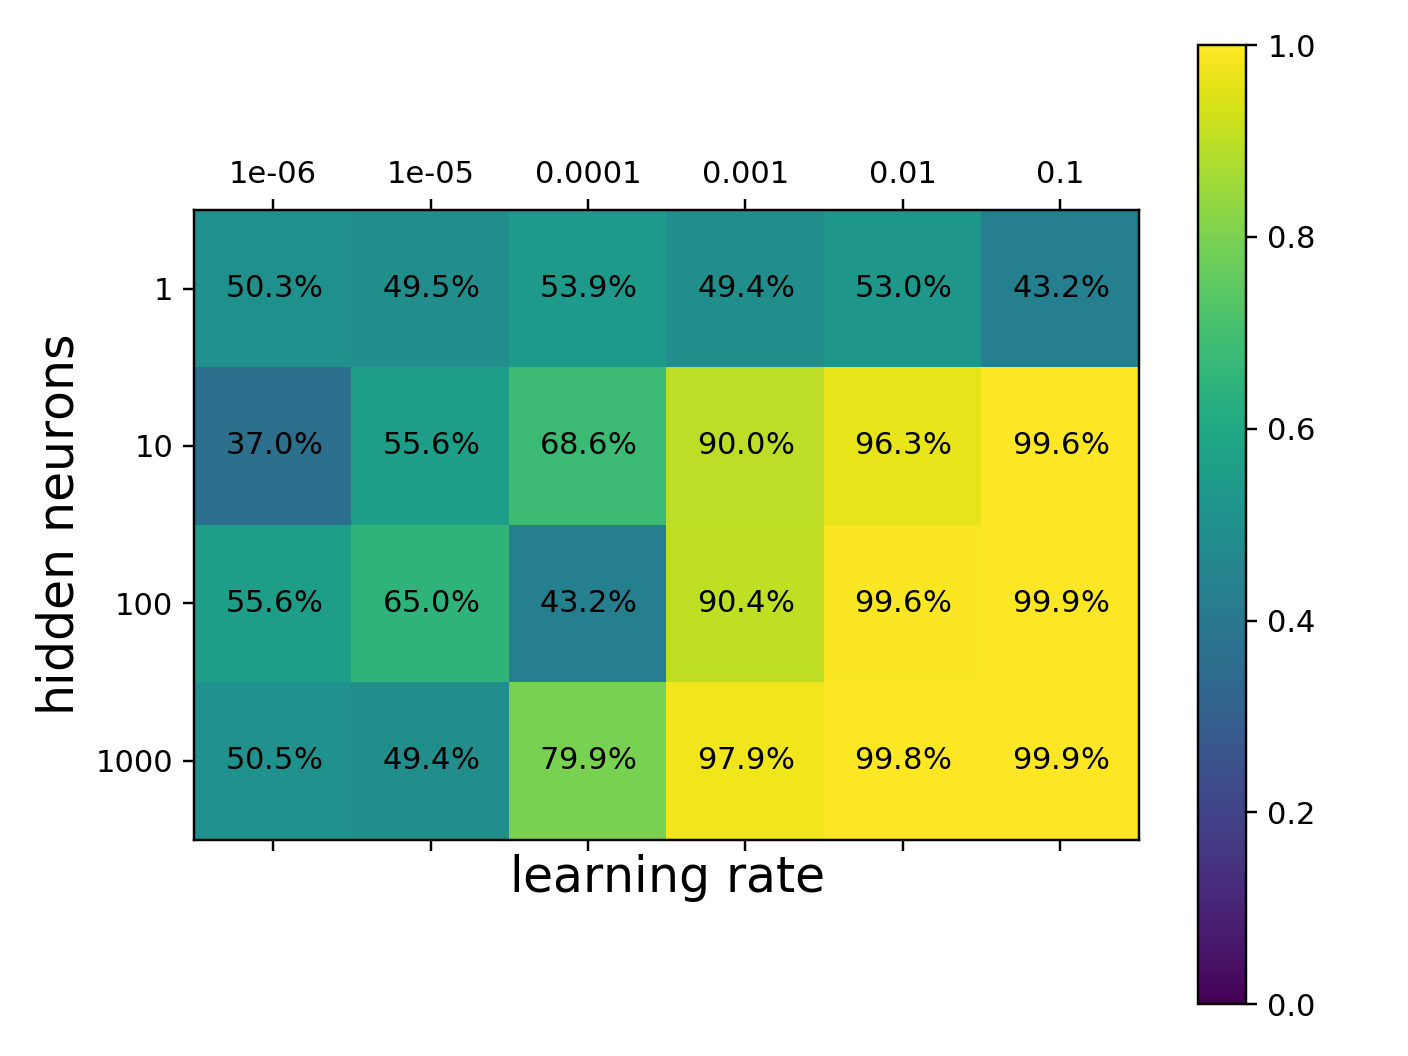

<IPython.core.display.Javascript object>


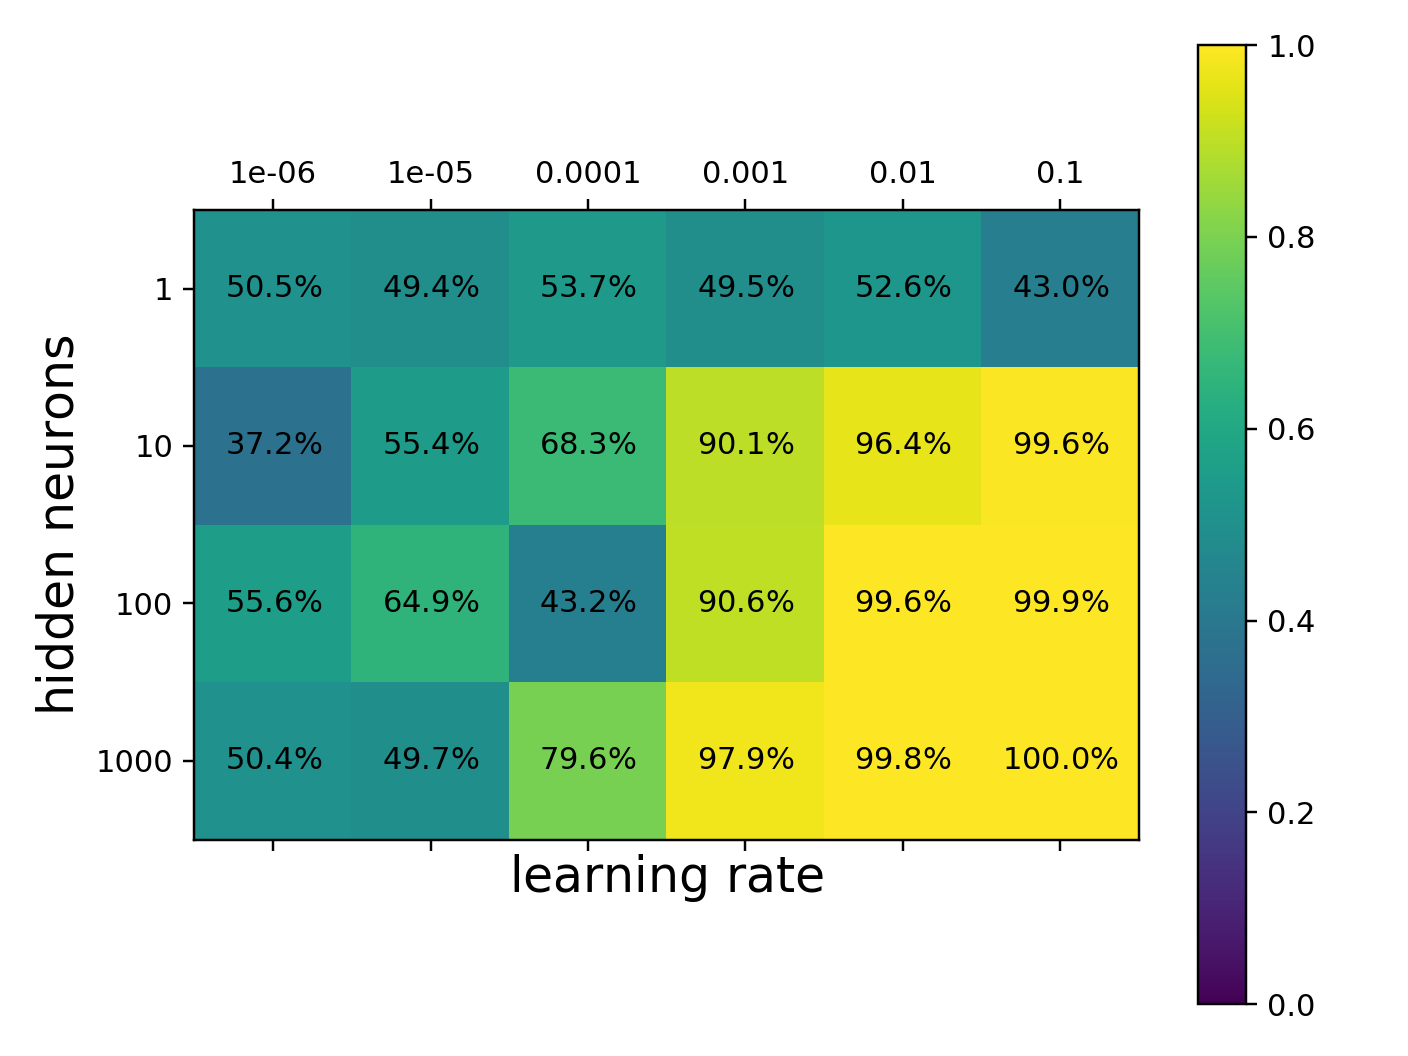

<IPython.core.display.Javascript object>


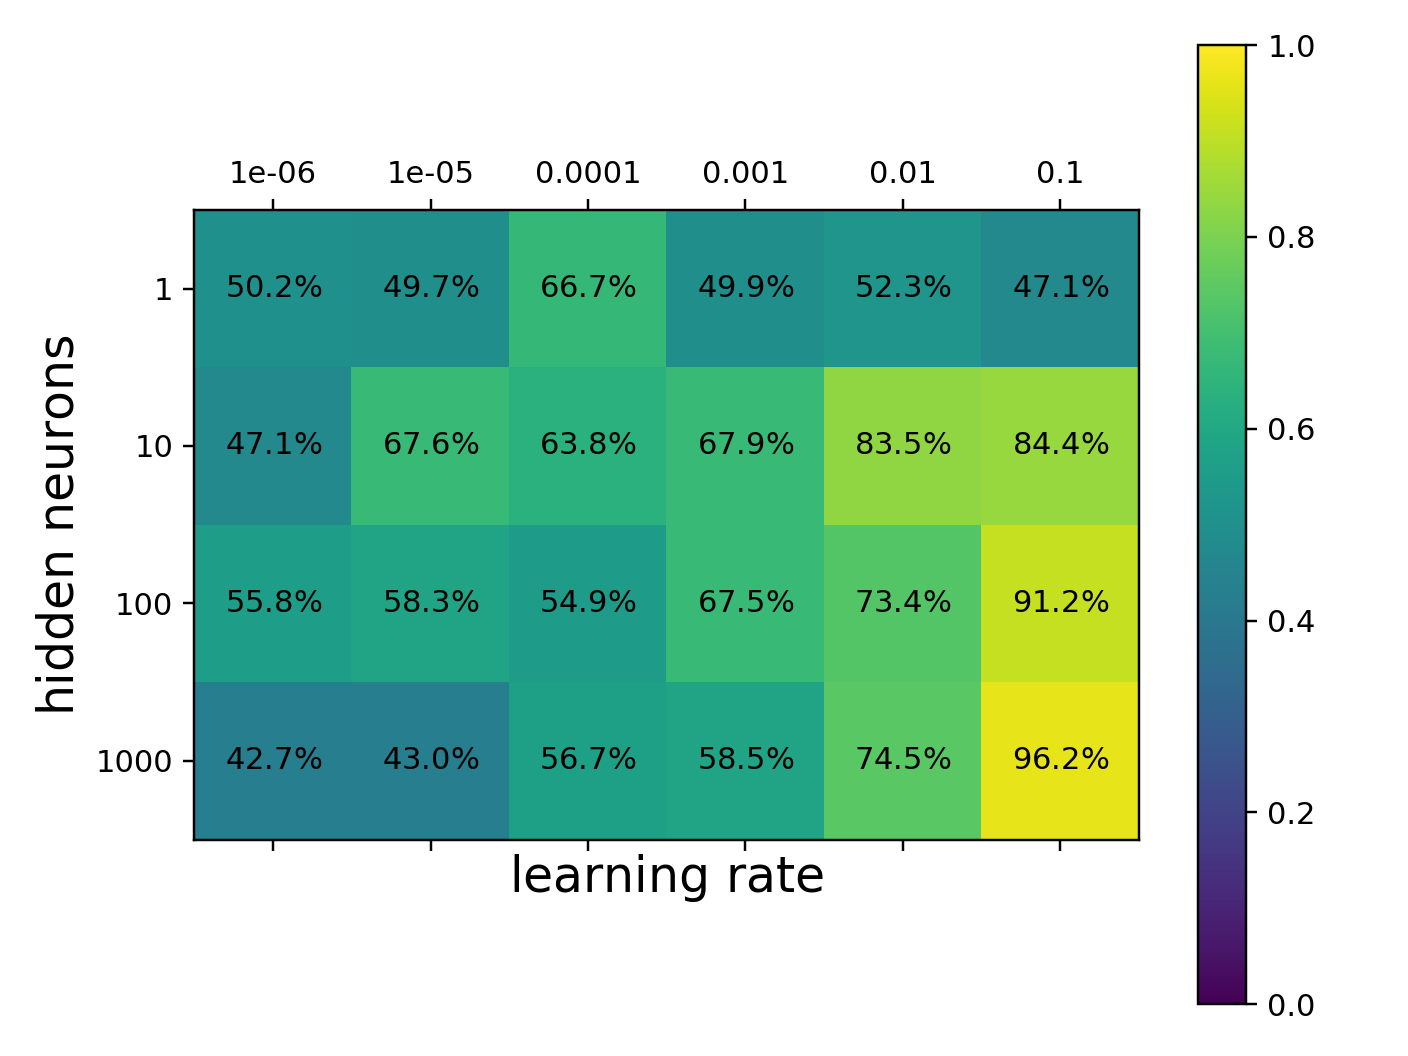

In [16]:
verbose=False
grid_search(verbose)

## Creating Convolutional Neural Nets with TensorFlow

We have so far considered each 2D-Ising state as a $(40\times 40,)$-long 1D vector. This approach neglects any spatial structure of the spin configuration. On the other hand, we do know that in every one of the 2D-Ising states there are *local* spatial correlations between the spins, which we would like to take advantage of to improve the accuracy of our classification model.

To this end, all we need to do is modify the class `model` to include convolutional layers. The code below is analogous to the DNN `model` class we discussed in detail above, except for the following noticeable discrepancies:

* note the auxiliary variable `X_reshaped` in the function `create_CNN` which casts the 2D-Ising configuration data as a 2D array, in order to bring out the spatial correlations.
* new below are the `conv2d` and `max_pool_2x2` functions which help create the convolutional structures of the network. 

In [17]:
class model(object):
    # build the graph for the CNN
    def __init__(self,opt_kwargs):

        # define global step for checkpointing
        self.global_step=tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

        self.L=40
        self.n_feats= self.L**2 
        self.n_categories=2

        # create placeholders for input X and label Y
        self.create_placeholders()
        # create weight and bias, initialized to 0 and construct CNN to predict Y from X
        self.create_CNN()
        # define loss function
        self.create_loss()
        # use gradient descent to minimize loss
        self.create_optimiser(opt_kwargs)
        # create accuracy
        self.create_accuracy()


        print("finished creating CNN")

    def create_placeholders(self):
        with tf.name_scope('data'):
            self.X=tf.placeholder(tf.float32, shape=(None,self.n_feats), name="X_data")
            self.Y=tf.placeholder(tf.float32, shape=(None,self.n_categories), name="Y_data")
            self.dropout_keepprob=tf.placeholder(tf.float32, name="keep_probability")


    def create_CNN(self, N_filters=10):
        with tf.name_scope('CNN'):
            # conv layer 1, 5x5 kernel, 1 input 10 output channels
            W_conv1 = self.weight_variable([5, 5, 1, N_filters],name='conv1',dtype=tf.float32) 
            b_conv1 = self.bias_variable([N_filters],name='conv1',dtype=tf.float32)
            X_reshaped = tf.reshape(self.X, [-1, self.L, self.L, 1])
            h_conv1 = tf.nn.relu(self.conv2d(X_reshaped, W_conv1, name='conv1') + b_conv1)

            # Pooling layer - downsamples by 2X.
            h_pool1 = self.max_pool_2x2(h_conv1,name='pool1')
            # conv layer 2, 5x5 kernel, 10 input 20 output channels
            W_conv2 = self.weight_variable([5, 5, 10, 20],name='conv2',dtype=tf.float32)
            b_conv2 = self.bias_variable([20],name='conv2',dtype=tf.float32)
            h_conv2 = tf.nn.relu(self.conv2d(h_pool1, W_conv2, name='conv2') + b_conv2)

            # Dropout - controls the complexity of the CNN, prevents co-adaptation of features.
            h_conv2_drop = tf.nn.dropout(h_conv2, self.dropout_keepprob,name='conv2_dropout')

            # Second pooling layer.
            h_pool2 = self.max_pool_2x2(h_conv2_drop,name='pool2')

            # Fully connected layer 1 -- after second round of downsampling, our 40x40 image
            # is down to 7x7x20 feature maps -- maps this to 50 features.
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*20])

            W_fc1 = self.weight_variable([7*7*20, 50],name='fc1',dtype=tf.float32)
            b_fc1 = self.bias_variable([50],name='fc1',dtype=tf.float32)

            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

            # Dropout - controls the complexity of the CNN, prevents co-adaptation of features.
            h_fc1_drop = tf.nn.dropout(h_fc1, self.dropout_keepprob,name='fc1_dropout')

            # Map the 50 features to 2 classes, one for each phase
            W_fc2 = self.weight_variable([50, self.n_categories],name='fc12',dtype=tf.float32)
            b_fc2 = self.bias_variable([self.n_categories],name='fc12',dtype=tf.float32)

            self.Y_predicted = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    def weight_variable(self, shape, name='', dtype=tf.float32):
        """weight_variable generates a weight variable of a given shape."""
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial,dtype=dtype,name=name)


    def bias_variable(self, shape, name='', dtype=tf.float32):
        """bias_variable generates a bias variable of a given shape."""
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial,dtype=dtype,name=name)


    def conv2d(self, x, W, name=''):
        """conv2d returns a 2d convolution layer with full stride."""
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID', name=name)


    def max_pool_2x2(self, x,name=''):
        """max_pool_2x2 downsamples a feature map by 2X."""
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1], 
                                padding='VALID',
                                name=name
                                )


    def create_loss(self):
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(
                            tf.nn.softmax_cross_entropy_with_logits(labels=self.Y,logits=self.Y_predicted)
                        ) 

    def create_optimiser(self,kwargs):
        with tf.name_scope('optimiser'):
            self.optimizer = tf.train.GradientDescentOptimizer(**kwargs).minimize(self.loss,global_step=self.global_step) 
            #self.optimizer = tf.train.AdamOptimizer(**kwargs).minimize(self.loss,global_step=self.global_step)

    def create_accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.Y, 1), tf.argmax(self.Y_predicted, 1))
            correct_prediction = tf.cast(correct_prediction, tf.float64)
            self.accuracy = tf.reduce_mean(correct_prediction)

## Exercises

* TensorFlow allows one to visualize the model as a graph. Read the [TensorBoard](https://www.tensorflow.org/get_started/graph_viz) documentation and implement this in the code above. 
* Read about using [TensorBoard](https://www.tensorflow.org/get_started/graph_viz) to monitor the training and test errors.
* Use the CNN `model` defined above to run the Ising classification analysis. Choose the optimal network architecture to improve on the results of the non-convolutional layer. To test the performance of the CNN, use the critical data set. 
* Does using the `Adam` optimizer improve on the performance on the critical data? Modify the CNN `model` class to do a grid search over the parameters of the `Adam` optimizer.